<a href="https://colab.research.google.com/github/Eizen724/PrProj/blob/main/PR_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation de pyngrok et configuration du token**

In [1]:
!pip install pyngrok
!pip install segno
!ngrok config add-authtoken 2UhH2p972yvHsZQTHaMKm1xyyJ8_7nZHAEW4CzJr91tkHTwQc

!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make


!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.0-py3-none-any.whl size=21129 sha256=01a4f1ec8b371276231be47a695605e4292a34c928123808fed63760d0317abd
  Stored in directory: /root/.cache/pip/wheels/60/29/7b/f64332aa7e5e88fbd56d4002185ae22dcdc83b35b3d1c2cbf5
Successfully built pyngrok
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 1.1 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 15833 (delta 157), reused 222 (delta 140), pack-reused 15539
Receiving objects: 100% (15833/15833), 14.75 MiB | 9.82 MiB/s, done.
Resolving deltas: 100% (10587/10587), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++

# **Code de l'api**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Public URL: https://b493-34-170-187-116.ngrok-free.app


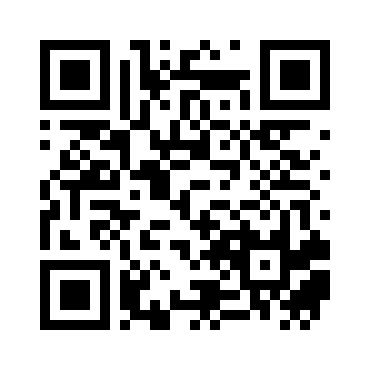

INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 07:55:25] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 07:55:30] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 07:55:32] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 07:55:37] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:03:39] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:03:45] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:03:56] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:03:57] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:04:00] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:04:05] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:04:10] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [09/Nov/2023 08:04:23] "POST /detect HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - 

In [3]:
import threading
import time
import segno
import os
import numpy as np
import cv2
import base64
from flask import Flask, request, jsonify
from werkzeug.serving import make_server
from google.colab import drive
from PIL import Image
from pyngrok import ngrok
from google.colab.patches import cv2_imshow
import asyncio

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/PR-PROJET/assets')

coco_class_id_to_label = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",
    8: "boat",
    9: "traffic light",
    10: "fire hydrant",
    11: "stop sign",
    12: "parking meter",
    13: "bench",
    14: "bird",
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    24: "backpack",
    25: "umbrella",
    26: "handbag",
    27: "tie",
    28: "suitcase",
    29: "frisbee",
    30: "skis",
    31: "snowboard",
    32: "sports ball",
    33: "kite",
    34: "baseball bat",
    35: "baseball glove",
    36: "skateboard",
    37: "surfboard",
    38: "tennis racket",
    39: "bottle",
    40: "wine glass",
    41: "cup",
    42: "fork",
    43: "knife",
    44: "spoon",
    45: "bowl",
    46: "banana",
    47: "apple",
    48: "sandwich",
    49: "orange",
    50: "broccoli",
    51: "carrot",
    52: "hot dog",
    53: "pizza",
    54: "donut",
    55: "cake",
    56: "chair",
    57: "couch",
    58: "potted plant",
    59: "bed",
    60: "dining table",
    61: "toilet",
    62: "screen",
    63: "laptop",
    64: "mouse",
    65: "remote",
    66: "keyboard",
    67: "cell phone",
    68: "microwave",
    69: "oven",
    70: "toaster",
    71: "sink",
    72: "refrigerator",
    73: "book",
    74: "clock",
    75: "vase",
    76: "scissors",
    77: "teddy bear",
    78: "hair drier",
    79: "toothbrush",
}

app = Flask(__name__)

yolo_weights = "/content/darknet/yolov3.weights"
yolo_cfg = "/content/darknet/cfg/yolov3.cfg"


net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

async def detect_objects_async(image):
    npimg = np.frombuffer(image, np.uint8)
    img = cv2.imdecode(npimg, cv2.IMREAD_COLOR)

    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(net.getUnconnectedOutLayersNames())

    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * img.shape[1])
                center_y = int(detection[1] * img.shape[0])
                width = int(detection[2] * img.shape[1])
                height = int(detection[3] * img.shape[0])
                x = int(center_x - width / 2)
                y = int(center_y - height / 2)
                boxes.append([x, y, width, height])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_id = class_ids[i]
            confidence = confidences[i]
            label = coco_class_id_to_label.get(class_id, "unknown")
            color = (0, 255, 0)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)

            label_text = f"{label}: {confidence:.2f}"
            cv2.putText(img, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 2)

    _, buffer = cv2.imencode(".jpg", img)
    img_base64 = base64.b64encode(buffer).decode()

    return jsonify({"image_with_objects": img_base64})

@app.route("/detect", methods=["POST"])
def detect_objects():
    image = request.files["image"].read()
    loop = asyncio.new_event_loop()
    result = loop.run_until_complete(detect_objects_async(image))
    loop.close()
    return result

class ServerThread(threading.Thread):
    def __init__(self):
        super().__init__()
        self.server = make_server('127.0.0.1', 5000, app)

    def run(self):
        self.server.serve_forever()

    def stop(self):
        self.server.shutdown()

def run_ngrok():
    time.sleep(1)
    ngrok_tunnel = ngrok.connect(5000)
    print('Public URL:', ngrok_tunnel.public_url)
    url = ngrok_tunnel.public_url
    qrcode = segno.make(url)
    qrcode.save('/content/drive/My Drive/PR-PROJET/assets/qrcode.png', scale=10)
    img = cv2.imread('qrcode.png')
    cv2_imshow(img)

if __name__ == '__main__':
    flask_thread = ServerThread()
    ngrok_thread = threading.Thread(target=run_ngrok)

    flask_thread.start()
    ngrok_thread.start()

    try:
        flask_thread.join()
    except KeyboardInterrupt:
        flask_thread.stop()
        flask_thread.join()

    ngrok_thread.join()
